In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scipy import stats
from sklearn.metrics import mean_squared_error


from jupyterthemes import jtplot
jtplot.style()

from wrangle import wrangle_zillow, split_zillow, scale_data

import explore

plt.rcParams['figure.figsize'] = (8,4)

# Analyzing and predicting customer churn
## Key findings:
-
- 

# Data acquisition and prep
- Data acquired from zillow sql database

In [2]:
zillow = wrangle_zillow()
zillow.head()

,bathrooms,bedrooms,square_feet,fips,latitude,longitude,lotsizesquarefeet,regionidzip,tax_value,taxes,transactiondate,age_in_years,Bathrooms_cat,Bedrooms_cat,tax_rate
parcelid,,,,,,,,,,,,,,,
11721753,2.0,3.0,1316.0,6037.0,34033180.0,-118355396.0,5672.0,95997.0,205123.0,2627.48,2017-07-21,98.0,2,2,1.28
11289917,2.0,3.0,1458.0,6037.0,34686163.0,-118113100.0,8284.0,97318.0,136104.0,2319.90,2017-06-23,51.0,2,2,1.70
11637029,2.0,3.0,1766.0,6037.0,34073222.0,-118390965.0,25082.0,96086.0,810694.0,9407.01,2017-07-28,41.0,2,2,1.16
11705026,1.0,2.0,1421.0,6037.0,33999877.0,-118291863.0,6707.0,96018.0,35606.0,543.69,2017-06-30,110.0,1,1,1.53
14269464,3.0,4.0,2541.0,6059.0,33694636.0,-117912245.0,4975.0,96958.0,880456.0,9819.72,2017-06-01,18.0,3,3,1.12


In [3]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32737 entries, 11721753 to 10713993
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bathrooms          32737 non-null  float64
 1   bedrooms           32737 non-null  float64
 2   square_feet        32737 non-null  float64
 3   fips               32737 non-null  float64
 4   latitude           32737 non-null  float64
 5   longitude          32737 non-null  float64
 6   lotsizesquarefeet  32737 non-null  float64
 7   regionidzip        32737 non-null  float64
 8   tax_value          32737 non-null  float64
 9   taxes              32737 non-null  float64
 10  transactiondate    32737 non-null  object 
 11  age_in_years       32737 non-null  float64
 12  Bathrooms_cat      32737 non-null  object 
 13  Bedrooms_cat       32737 non-null  object 
 14  tax_rate           32737 non-null  float64
dtypes: float64(12), object(3)
memory usage: 4.0+ MB


## Exploration

In [4]:
# splitting columns between categorical and quantitative for explore functions
cat_vars = ['fips', 'Bedrooms_cat', 'Bathrooms_cat']

quant_vars = ['square_feet',                         
              'lotsizesquarefeet',              
              'tax_value',
              'taxes',              
              'age_in_years',
              'tax_rate'
              ]

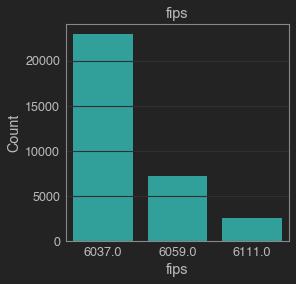

          fips  Count  Percent
6037.0  6037.0  22927    70.03
6059.0  6059.0   7221    22.06
6111.0  6111.0   2589     7.91
_________________________________________________________________


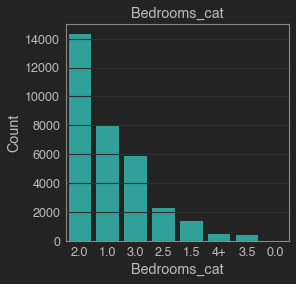

    Bedrooms_cat  Count  Percent
2.0            2  14311    43.72
3.0            1   7978    24.37
1.0            3   5885    17.98
2.5          2.5   2276     6.95
4+           1.5   1372     4.19
1.5           4+    479     1.46
3.5          3.5    396     1.21
0.0            0     40     0.12
_________________________________________________________________


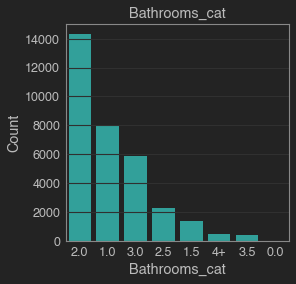

    Bathrooms_cat  Count  Percent
2.0             2  14311    43.72
3.0             1   7978    24.37
1.0             3   5885    17.98
2.5           2.5   2276     6.95
4+            1.5   1372     4.19
1.5            4+    479     1.46
3.5           3.5    396     1.21
0.0             0     40     0.12
_________________________________________________________________


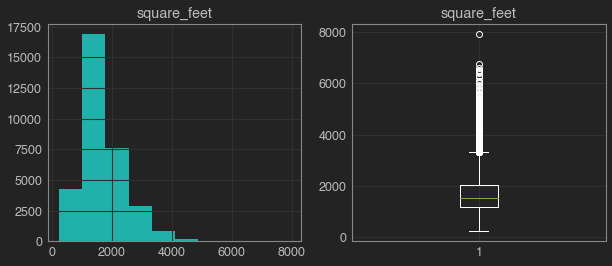

count    32737.000000
mean      1691.697926
std        716.465814
min        240.000000
25%       1189.000000
50%       1528.000000
75%       2039.000000
max       7942.000000
Name: square_feet, dtype: float64


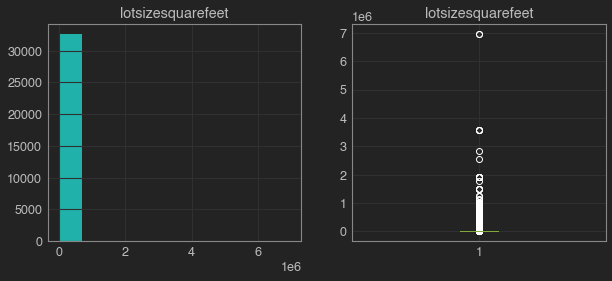

count    3.273700e+04
mean     3.040644e+04
std      1.138988e+05
min      2.360000e+02
25%      5.712000e+03
50%      7.200000e+03
75%      1.150000e+04
max      6.971010e+06
Name: lotsizesquarefeet, dtype: float64


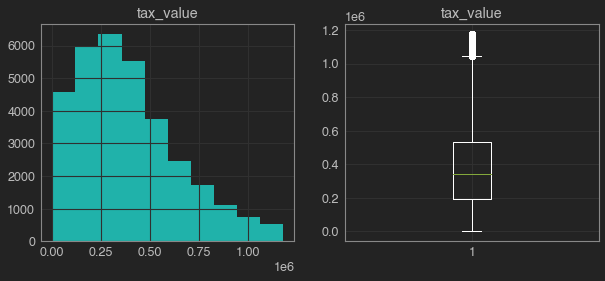

count    3.273700e+04
mean     3.895280e+05
std      2.533097e+05
min      1.000000e+03
25%      1.945800e+05
50%      3.441140e+05
75%      5.336390e+05
max      1.178048e+06
Name: tax_value, dtype: float64


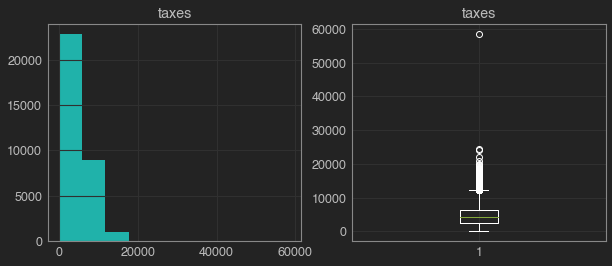

count    32737.000000
mean      4835.386009
std       2994.294512
min         19.920000
25%       2605.250000
50%       4306.820000
75%       6445.660000
max      58634.770000
Name: taxes, dtype: float64


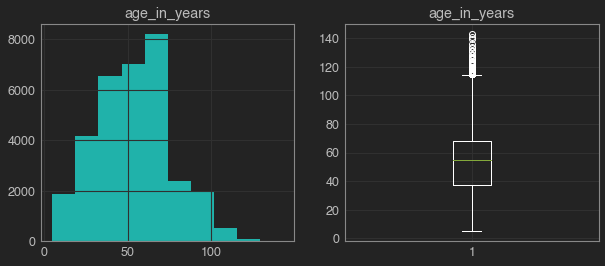

count    32737.000000
mean        54.006842
std         22.200494
min          5.000000
25%         37.000000
50%         55.000000
75%         68.000000
max        143.000000
Name: age_in_years, dtype: float64


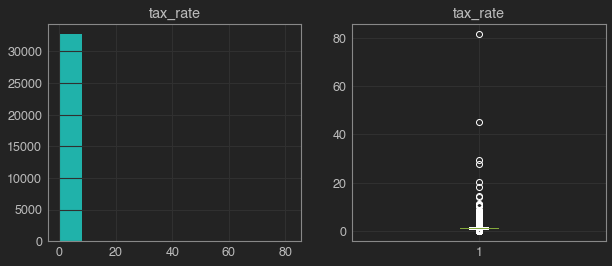

count    32737.000000
mean         1.330349
std          0.681460
min          0.010000
25%          1.180000
50%          1.230000
75%          1.360000
max         81.650000
Name: tax_rate, dtype: float64


In [5]:
#explore.py function to visualize single category data
explore.explore_univariate(zillow, cat_vars, quant_vars)

<AxesSubplot:xlabel='tax_rate', ylabel='Density'>

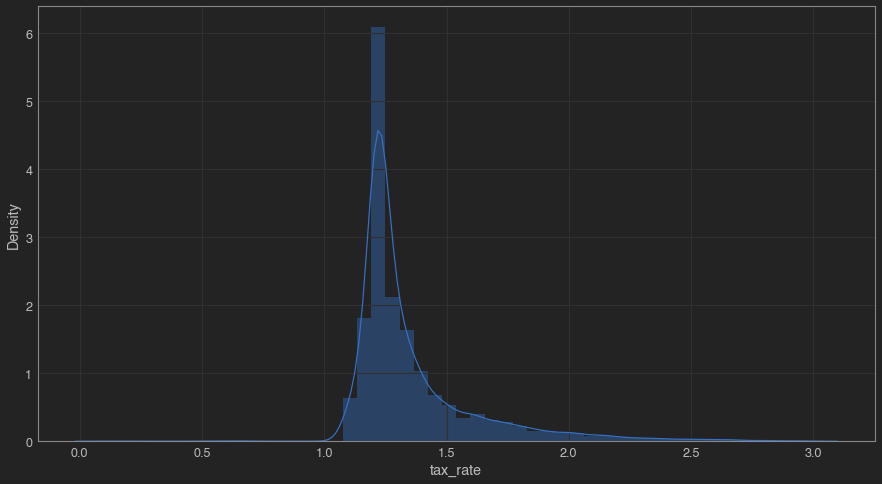

In [102]:
#tax rate distribution for LA county
plt.figure(figsize=(15,8))
sns.distplot(zillow[(zillow.fips == 6037)&(zillow.tax_rate < 3)].tax_rate)

<AxesSubplot:xlabel='tax_rate', ylabel='Density'>

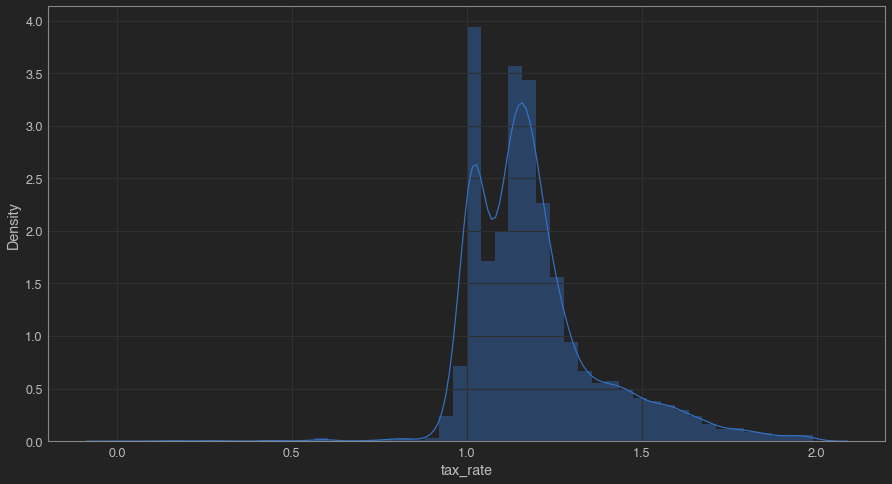

In [103]:
#tax rate distribution for Orange county
plt.figure(figsize=(15,8))
sns.distplot(zillow[(zillow.fips == 6059)&(zillow.tax_rate < 2)].tax_rate)

<AxesSubplot:xlabel='tax_rate', ylabel='Density'>

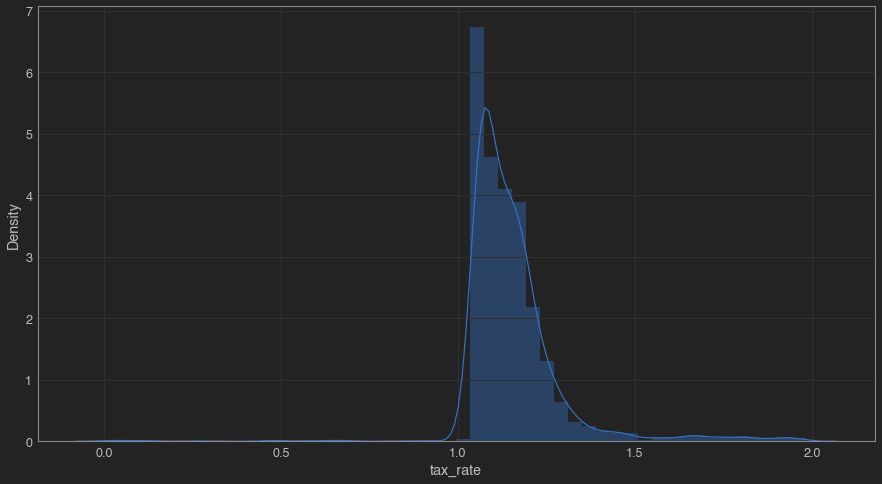

In [104]:
#tax rate distribution for Ventura county
plt.figure(figsize=(15,8))
sns.distplot(zillow[(zillow.fips == 6111)&(zillow.tax_rate < 2)].tax_rate)

##### Univariate Takeaways
- 70% of single unit properties are in LA county (6037)
- median home age is 55 years
- median square footage is 1528 sqft
- median tax value is $344,114.0

In [6]:
train, validate, test = split_zillow(zillow)

fips 
_____________________

          chi2       p-value  degrees of freedom
0  39478.75889  1.497634e-33               36152

observed:
 tax_value  1000.0  11683.0  14284.0  14439.0  15692.0  16084.0  16305.0  \
fips                                                                      
6037.0          1        1        1        1        1        1        1   
6059.0          0        0        0        0        0        0        0   
6111.0          0        0        0        0        0        0        0   
All             1        1        1        1        1        1        1   

tax_value  16514.0  16722.0  16723.0  ...  1177141.0  1177308.0  1177488.0  \
fips                                  ...                                    
6037.0           1        1        1  ...          0          0          1   
6059.0           0        0        0  ...          1          1          0   
6111.0           0        0        0  ...          0          0          0   
All              1  

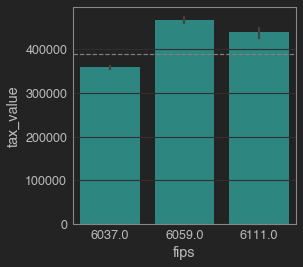


_____________________

Bedrooms_cat 
_____________________

            chi2       p-value  degrees of freedom
0  133050.634065  1.697372e-37              126532

observed:
 tax_value     1000.0  11683.0  14284.0  14439.0  15692.0  16084.0  16305.0  \
Bedrooms_cat                                                                 
0.0                0        0        0        0        0        0        0   
1.0                0        1        1        1        1        1        1   
1.5                0        0        0        0        0        0        0   
2.0                0        0        0        0        0        0        0   
2.5                0        0        0        0        0        0        0   
3.0                0        0        0        0        0        0        0   
3.5                0        0        0        0        0        0        0   
4+                 1        0        0        0        0        0        0   
All                1        1        1       

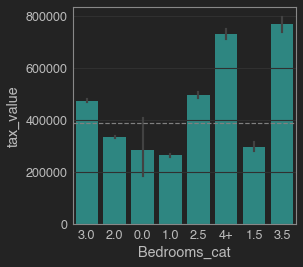


_____________________

Bathrooms_cat 
_____________________

            chi2       p-value  degrees of freedom
0  133050.634065  1.697372e-37              126532

observed:
 tax_value      1000.0  11683.0  14284.0  14439.0  15692.0  16084.0  16305.0  \
Bathrooms_cat                                                                 
0.0                 0        0        0        0        0        0        0   
1.0                 0        1        1        1        1        1        1   
1.5                 0        0        0        0        0        0        0   
2.0                 0        0        0        0        0        0        0   
2.5                 0        0        0        0        0        0        0   
3.0                 0        0        0        0        0        0        0   
3.5                 0        0        0        0        0        0        0   
4+                  1        0        0        0        0        0        0   
All                 1        1    

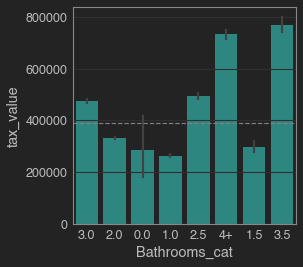


_____________________

  
____________________



KeyError: 'Column not found:  '

In [10]:
# explore function to compare variables to the target of 'tax_value'
explore.explore_bivariate(train, 'tax_value', cat_vars, ' ' )

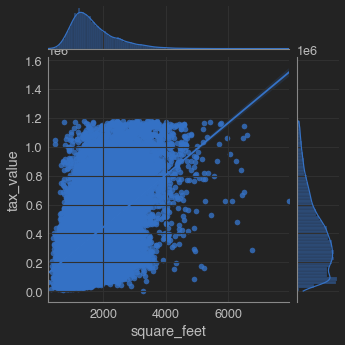

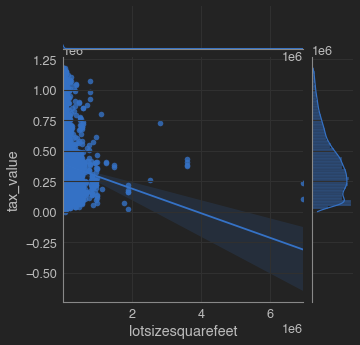

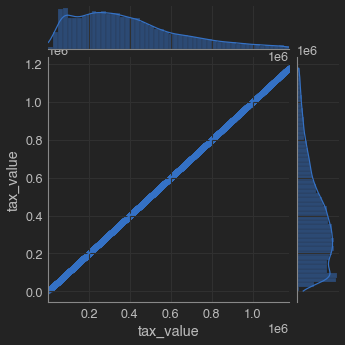

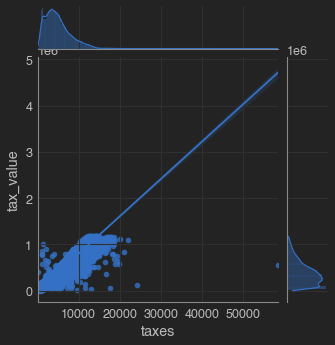

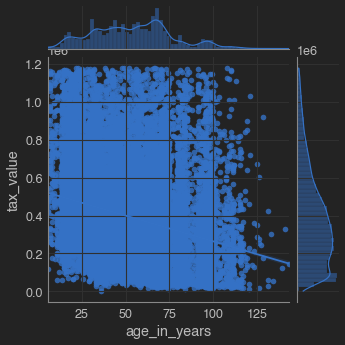

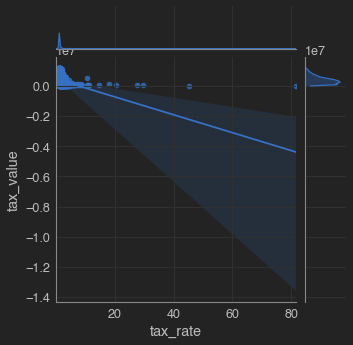

In [12]:
for col in quant_vars:
    sns.jointplot(col, "tax_value", data=train, kind='reg', height=5);
    plt.show()

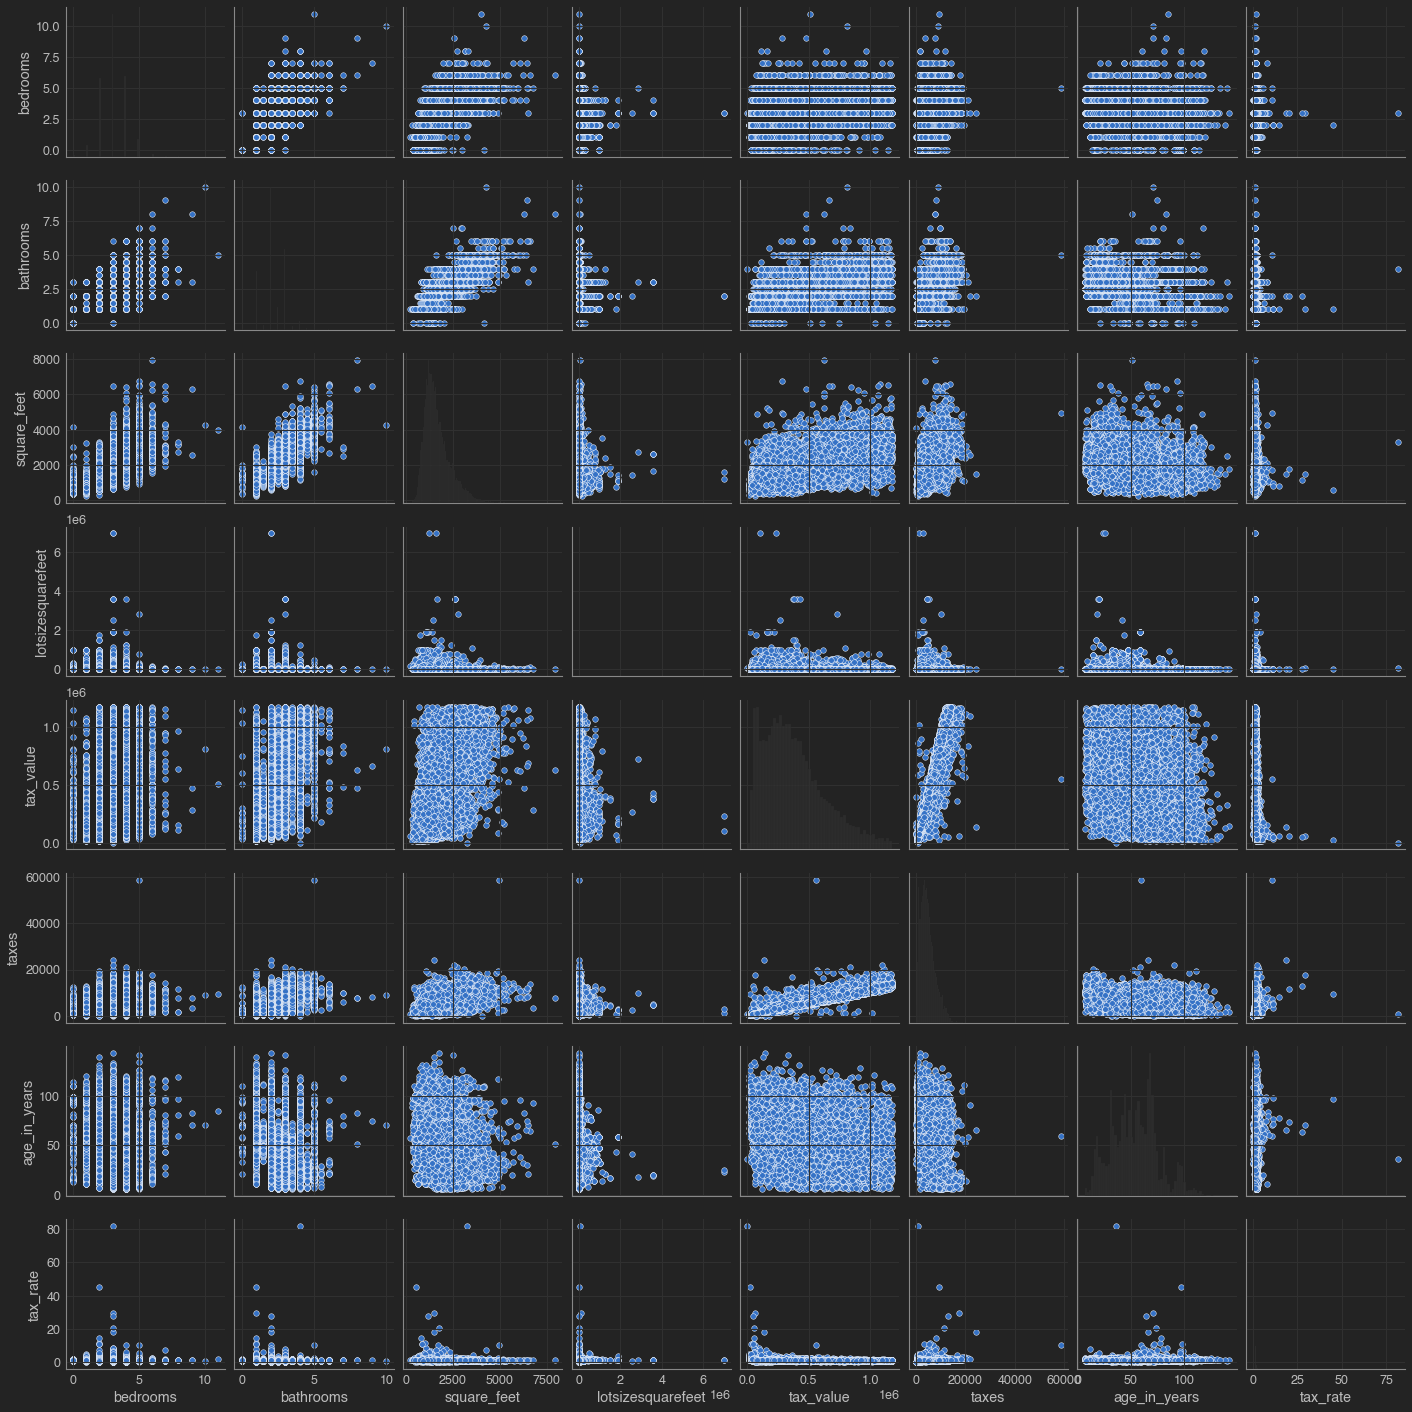

In [23]:
plot_vars = ['bedrooms',
             'bathrooms',
             'square_feet',
             'lotsizesquarefeet',
             'tax_value',
             'taxes',
             'age_in_years',
             'tax_rate']
sns.pairplot(train[plot_vars])

(0.0, 4.0)

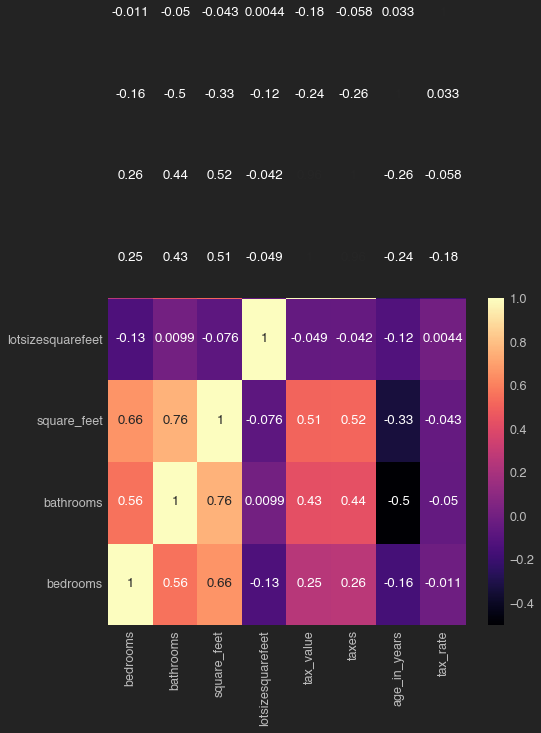

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(train[plot_vars].corr(), cmap='magma', annot=True)
plt.ylim(0, 4)

##### Bivariate Takeaways
- The highest tax values are in LA county (6059)
- Tax value increases significantly with more than 3 bedrooms and bathrooms
- Square footage has a positive correlation with tax value

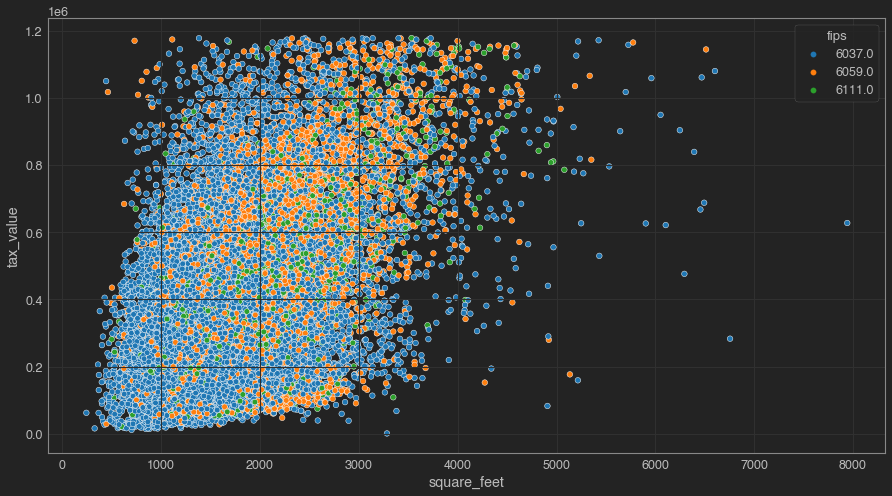

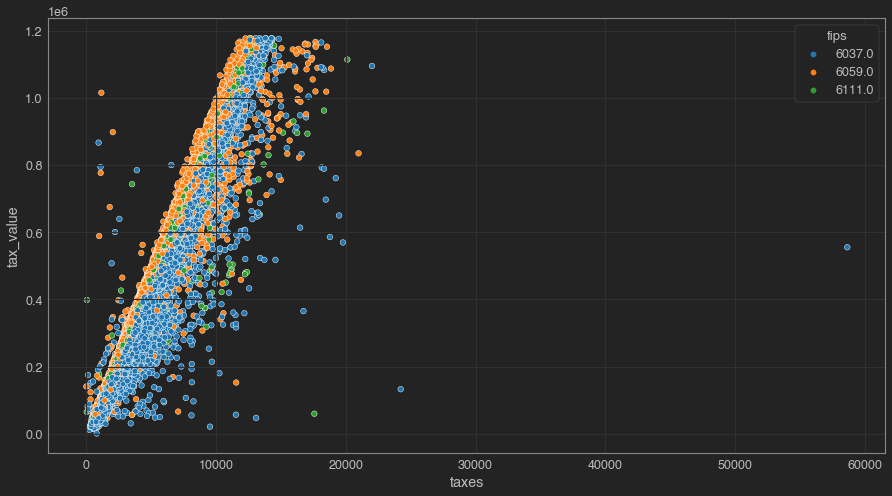

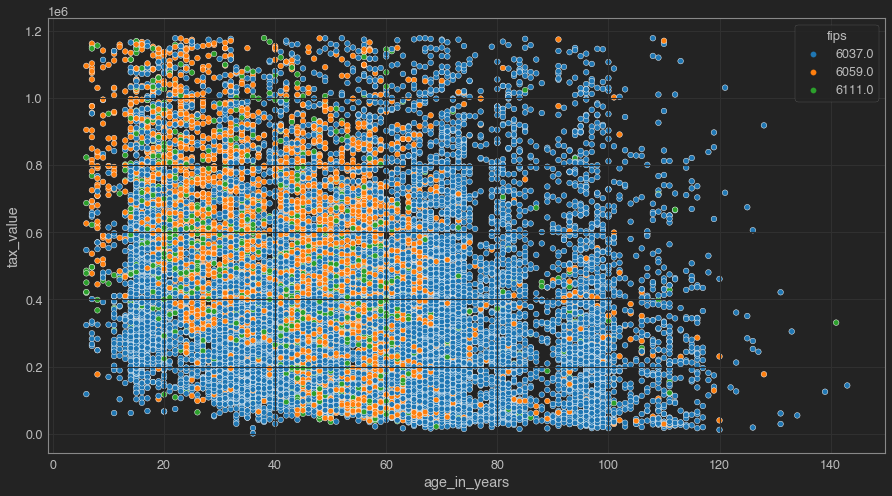

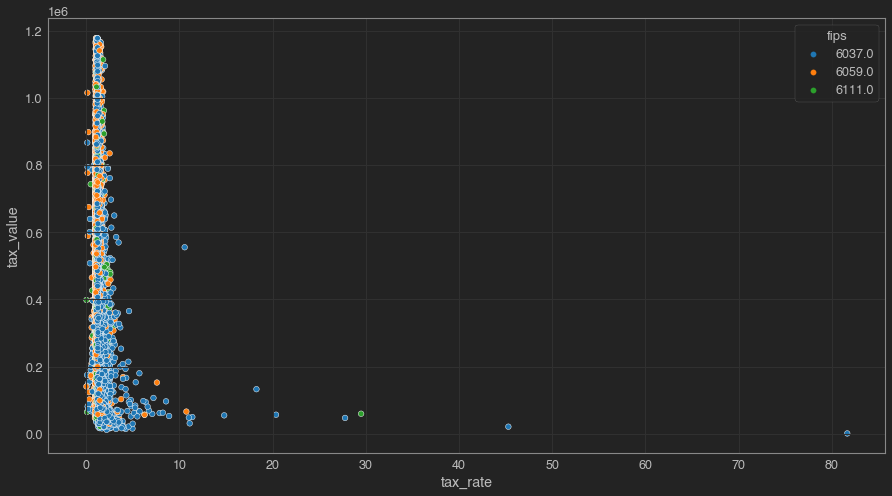

In [73]:
#Narrowing down variables for use with multivariate function. This function compares two categories and separates churn by hue
plot_vars = ['square_feet','taxes','age_in_years','tax_rate']
for col in plot_vars:
    plt.figure(figsize=(15,8))
    sns.scatterplot(col,'tax_value',hue='fips',data=train,palette='tab10')

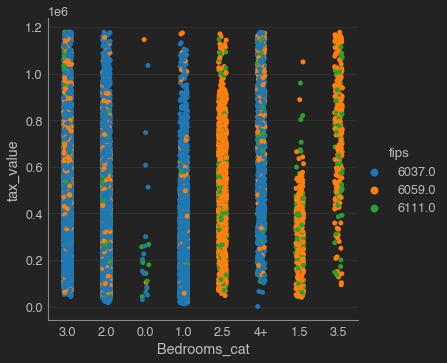

In [110]:
sns.catplot(hue='fips',x='Bedrooms_cat',y='tax_value',data=train, palette='tab10')

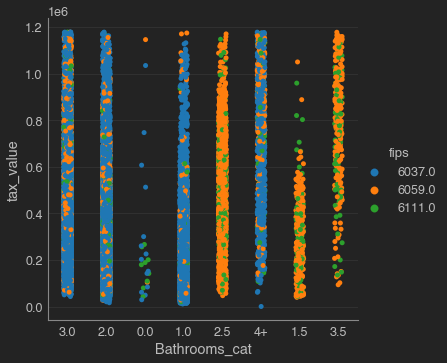

In [111]:
sns.catplot(hue='fips',x='Bathrooms_cat',y='tax_value',data=train, palette='tab10')

##### Multivariate Takeaways
- LA county has most of the older homes (age 60+ years)
- Looks to be a slight negative correlation between age and tax value
- Orange county dominates the 1.5,2.5, and 3.5 bed/bath categories while LA county dominates 1,2,3,and 4+ bed/bath

### 1. Is the mean tax value significantly different between LA and other counties?

In [116]:
null_hypothesis = "The mean tax values are the same between counties"
alternative_hypothesis = "The mean tax values are significantly different between counties"
confidence_level = .95
a = 1 - confidence_level 

In [112]:
#subsetting counties from train data
LA = train[train.fips == 6037]
Ventura_Orange = train[train.fips != 6037]

In [114]:
#one tailed two sample t-test for independence
t, p = stats.ttest_ind(LA.tax_value, Ventura_Orange.tax_value)
t, p

(-27.898434829922593, 1.8178925125905907e-168)

In [118]:
if p < a:
    print('We reject the null')
else:
    print("we fail to reject the null")

We reject the null


In [119]:
print('The mean tax_values for LA county is significantly different than Ventura and Orange counties')

The mean tax_values for LA county is significantly different than Ventura and Orange counties


In [113]:
#verification
LA.tax_value.mean(), Ventura_Orange.tax_value.mean()

(358903.67186626064, 459546.66896248533)

In [120]:
#checking medians
LA.tax_value.median(), Ventura_Orange.tax_value.median()

(309820.0, 431326.0)

### 2. Is there a correlation between home age and tax_value?

In [121]:
null_hypothesis = "There is no correlation between home age and tax_value"
alternative_hypothesis = "There is a negative correlation between home age and tax value"
confidence_level = .95
a = 1 - confidence_level

In [122]:
#Pearson correlation test between two continuous variables
r, p = stats.pearsonr(train.age_in_years, train.tax_value)
r, p

(-0.23880765398020834, 1.524836882919844e-294)

In [123]:
if p < a:
    print('We reject the null')
else:
    print("we fail to reject the null")

We reject the null


In [ ]:
print('There is weak negative correlation between home age and tax value')

### 3. Is there a correlation between square_feet and tax value?

In [124]:
null_hypothesis = "There is no correlation between square_feet and tax_value"
alternative_hypothesis = "There is a positive correlation between square_feet and tax_value"
confidence_level = .95
a = 1 - confidence_level

#Pearson correlation test between two continuous variables
r, p = stats.pearsonr(train.square_feet, train.tax_value)
r, p

(0.5125372690565347, 0.0)

In [125]:
if p < a:
    print('We reject the null')
else:
    print("we fail to reject the null")
    
print('Pearson correlation = ', r)
print('There is a moderate positive correlation between square_feet and tax_value')

We reject the null
Pearson correlation =  0.5125372690565347
There is a moderate positive correlation between square_feet and tax_value


# Modeling and Evaluation
- Creating all 3 types of regression models using mostly default settings then choosing the best performing

In [126]:
#MVP features
features = ['bedrooms','bathrooms','square_feet']

X_train_mvp = train[features]
y_train_mvp = train.tax_value

X_validate_mvp = validate[features]
y_validate_mvp = validate.tax_value

X_test_mvp = test[features]
y_test_mvp = test.tax_value

In [ ]:
#setting baseline
train.churn.value_counts()

In [ ]:
#baseline is 0 == no churn
train['baseline_prediction'] = 0
train.head(1)

In [ ]:
baseline_accuracy = (train.churn == train.baseline_prediction).mean()
baseline_accuracy

### Baseline accuracy ~ 73%

In [ ]:
#Narrowing down features based on previous hypothesis testing. Partner and dependents were included just based on analysis from previous project
features = ['tenure','monthly_charges','partner','dependents','Month_to_month',
            'One_year_contract','Two_year_contract','DSL','Fiber_optic','No_internet']

X_train = train[features]
y_train = train.churn 

X_validate = validate[features]
y_validate = validate.churn

X_test = test[features]
y_test = test.churn

## Model 1: Decision Tree

In [ ]:
clf = DecisionTreeClassifier(max_depth=5, random_state=123)
clf = clf.fit(X_train,y_train)

In [ ]:
#training data report
decision_tree_report = get_metrics(clf, X_train, y_train)
decision_tree_report

In [ ]:
#validate data report
decision_tree_report_validate = get_metrics(clf,X_validate,y_validate)
decision_tree_report_validate

## Model 2: Random Forest

In [ ]:
rf = RandomForestClassifier(bootstrap=True,
                            class_weight=None,
                            criterion='gini',
                            min_samples_leaf=5,
                            n_estimators=100,
                            max_depth=5,
                            random_state=123)
rf = rf.fit(X_train, y_train)

In [ ]:
#training data report
rf_report = get_metrics(rf,X_train,y_train)
rf_report

In [ ]:
#validate data report
rf_report_validate = get_metrics(rf,X_validate,y_validate)
rf_report_validate

## Model 3: KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

#training data report
knn_report = get_metrics(knn,X_train,y_train)
knn_report

In [ ]:
#validate data report
knn_report_validate = get_metrics(knn,X_validate,y_validate)
knn_report_validate

## Model 4: Logistic Regression

In [ ]:
logit = LogisticRegression(C=1, class_weight='balanced',
                           random_state=123,solver='liblinear')
logit = logit.fit(X_train, y_train)

#training data report
log_report = get_metrics(logit,X_train,y_train)
log_report

In [ ]:
#validate data report
log_report_validate = get_metrics(logit,X_validate,y_validate)
log_report_validate

# Logistic Regression model chosen for it's high recall compared to other models
- False negative churn predictions are more costly so a high recall is necessary

In [ ]:
#test data report
log_report_test = get_metrics(logit, X_test,y_test)
log_report_test

In [ ]:
#creating churn predictions and probabilities using test dataset and log model and outputing to .csv
telco_predict = telco[features]
prediction = logit.predict(telco_predict)
prediction_probability = logit.predict_proba(telco_predict)
prediction, prediction_probability

In [ ]:
#new predictions dataframe
predicted_df = pd.concat([telco.customer_id,pd.DataFrame(prediction_probability[0:,1]),pd.DataFrame(prediction)],axis=1)
predicted_df.columns = ['customer_id', 'probability_of_churn', 'churn_prediction']
predicted_df

In [ ]:
predicted_df.to_csv('churn_predictions.csv')

In [ ]:
#accuracy of predictions compared to actual churn
(telco.churn == predicted_df.churn_prediction).mean()

# Key Takeaways
- We need to address the high rate of churn for our month-to-month and fiber optic customers
- Current models aren't much more accurate than baseline but logistic regression model had highest recall of 0.82
- With more time I would tweak each model to maximize performance and possibly add features